# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Признаки

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
# Целевой признак

- Exited — факт ухода клиента

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.utils import shuffle


#Импортируем необходимые метики
#метика accuracy
from sklearn.metrics import accuracy_score

#матрица ошибок
from sklearn.metrics import confusion_matrix

#полнота
from sklearn.metrics import recall_score

#точность
from sklearn.metrics import precision_score

#F-1 мера
from sklearn.metrics import f1_score

#AUC-ROC
from sklearn.metrics import roc_auc_score

#ROC-кривая
from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data['Geography'].unique()


array(['France', 'Spain', 'Germany'], dtype=object)

In [5]:
data['Tenure'] = data['Tenure'].fillna(-1)

In [6]:
data.duplicated().sum()

0

- Признаки RowNumber, CustomerId и Surname не несут в себе информации, необходимой для дальнейшей классификации (RowNumber — столбец дублирует информацию стандартного датафрейма, CustomerId — является идентификатором пользователя, Surname — является идентифицирующей пользователя информацией.) Уберем их.
- CreditScore — проверим распределение и оставим его.
- Geography — всего 3 значения France', 'Spain', 'Germany' — сделаем преобразование OHE / ordinal encoding
- Gender — так же в — OHE / ordinal encoding.
- Age — Exited — тип данных верны, требуется проработка OHE.

# Подготавяливаем данные для машинного обучения

In [7]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Подготовим данные методом ОНЕ для дальнейшего использования моделей (случайный лес, дерево решений, логистическая регрессия)

In [8]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


<div class="alert alert-block alert-success">
<b>Успех:</b> OHE – наиболее подходящий метод для кодировки категориальных колонок в данном случае.
</div>

In [9]:
data.shape

(10000, 12)

В полученном датафрейме у нас 12 столбцов.
- Столбец Geography содержал 3 класса 
- Gender_Male 2 класса — в результате мы получили только 2 и 1 столбцов соответственно, тем самым избегаем дамми-ловушки

Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1 соответственно (60% на обучающию и по 20% данных на валидационную и тестовую выборки).

In [10]:
features = data.drop('Exited', axis=1)
target = data['Exited']

In [11]:
X, X_test, y, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=123)


In [12]:
# выведем размеры получившихся выборок
print('Размеры наборов данных:')
print('X_train: ', X_train.shape)
print('X_valid: ', X_valid.shape)
print('X_test:  ', X_test.shape)

Размеры наборов данных:
X_train:  (6000, 11)
X_valid:  (2000, 11)
X_test:   (2000, 11)


Полученые выбрки:
- Обучающая
X_train,
y_train

- Валидационная
X_valid,
y_valid

- Тестовая
X_test,
y_test

# Масштабирование признаков

In [13]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8189,715,21,8.0,0.00,2,1,0,68666.63,0,0,1
8845,729,39,1.0,131513.26,1,1,1,193715.00,1,0,0
1165,712,49,5.0,154776.42,2,0,0,196257.68,1,0,0
1742,584,54,1.0,77354.37,1,0,0,138192.98,1,0,0
1139,727,57,1.0,109679.72,1,0,1,753.37,0,1,0


In [14]:
#Для масштабирования зафиксируем численные признаки
numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [15]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])

StandardScaler()

In [16]:
#Масштабируем численные признаки обучающей выборки 
X_train[numeric] = scaler.transform(X_train[numeric])
X_train.head()

/tmp/ipykernel_563/1068312076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric] = scaler.transform(X_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8189,0.652468,-1.698690,8.0,-1.213083,0.781092,1,0,-0.535390,0,0,1
8845,0.796864,0.002583,1.0,0.886952,-0.920634,1,1,1.637287,1,0,0
1165,0.621526,0.947735,5.0,1.258423,0.781092,0,0,1.681465,1,0,0
1742,-0.698668,1.420312,1.0,0.022130,-0.920634,0,0,0.672609,1,0,0
1139,0.776236,1.703857,1.0,0.538309,-0.920634,0,1,-1.715362,0,1,0


In [17]:
#Масштабируем численные признаки валидационной выборки 
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_valid.head()

/tmp/ipykernel_563/1427102451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[numeric] = scaler.transform(X_valid[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
1361,-0.760552,-0.659023,4.0,-1.213083,0.781092,1,1,0.735676,0,0,1
2739,-0.275793,0.569675,7.0,0.983435,-0.920634,0,0,0.436569,0,0,1
1963,-0.760552,-0.469993,-1.0,1.142028,0.781092,1,0,-0.569894,1,0,1
9799,0.012999,0.664190,0.0,0.696017,-0.920634,1,0,-0.368880,0,0,1
1023,-0.100455,-0.659023,3.0,-1.213083,0.781092,1,1,-0.187337,0,0,1


In [18]:
#Масштабируем численные признаки тестовой выборки 
X_test[numeric] = scaler.transform(X_test[numeric])
X_test.head()

/tmp/ipykernel_563/1567446198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric] = scaler.transform(X_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2656,1.312565,-0.469993,5.0,-1.213083,0.781092,0,1,0.211895,0,1,0
445,0.992830,-1.226114,1.0,0.028931,-0.920634,0,1,1.451976,0,0,0
9505,-0.007629,-1.037084,10.0,0.057397,-0.920634,1,1,-0.430782,0,0,1
332,0.116139,0.475159,2.0,0.655657,0.781092,0,1,0.785322,1,0,1
4168,-1.400021,-0.186447,8.0,-1.213083,-0.920634,1,0,0.040893,0,0,1


Получили масштабированные признаки для трех выборок. Теперь перейдем к исследованию задач

## Исследование задачи

Точность разных моделей


In [19]:
def all_models_accuracy(X_train, y_train, X_valid, y_valid):
    model_DTC = DecisionTreeClassifier(random_state=123)
    DTC_score = model_DTC.fit(X_train, y_train).score(X_valid, y_valid)
    
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
    RFC_score = model_RFC.fit(X_train, y_train).score(X_valid, y_valid)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    LgR_score = model_LgR.fit(X_train, y_train).score(X_valid, y_valid)
    print("Точность:" "дерево решений", DTC_score, "случайный лес ", RFC_score, "логистическая регрессия", LgR_score)

In [20]:
all_models_accuracy(X_train, y_train, X_valid, y_valid)

Точность:дерево решений 0.772 случайный лес  0.857 логистическая регрессия 0.801


Проверим баланс классов

In [21]:
y_train.value_counts(normalize = 1)

0    0.7995
1    0.2005
Name: Exited, dtype: float64

In [22]:
y_valid.value_counts(normalize = 1)

0    0.79
1    0.21
Name: Exited, dtype: float64

У обучающией и валидационной выборок наблюдается выраженный дисбаланс класов. Ответы 0 ≈80% , 1 ≈ 20%
Результаты предсказаний моделей будут сильно склоняться к одному варианту ответов.

Какое соотношение ответов дает модель

In [23]:
def all_models_share(X_train, y_train, X_valid, y_valid):
    model_DTC = DecisionTreeClassifier(random_state=123)
    model_DTC.fit(X_train, y_train)
    DTC_share = pd.Series(model_DTC.predict(X_valid)).value_counts(normalize = 1)
    
    
    
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
    model_RFC.fit(X_train, y_train)
    RFC_share = pd.Series(model_RFC.predict(X_valid)).value_counts(normalize = 1)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    model_LgR.fit(X_train, y_train)
    LgR_share = pd.Series(model_LgR.predict(X_valid)).value_counts(normalize = 1)
    

    
    print("Доли ответов:" "дерево решений", DTC_share, "случайный лес ", RFC_share, "логистическая регрессия", LgR_share , end='')
    
all_models_share(X_train, y_train, X_valid, y_valid)

Доли ответов:дерево решений 0    0.782
1    0.218
dtype: float64 случайный лес  0    0.879
1    0.121
dtype: float64 логистическая регрессия 0    0.937
1    0.063
dtype: float64

Логистическая регрессия выдает 100% негативных предсказаний — высокая точность модели объясняется высокой долей негативных ответов в валидационной выборке.

### Обучим модели без учета дисбаланса классов

#### Решающее дерево

In [24]:
def decision_tree(X_train, X_valid, y_train, y_valid, cw=None):
    best_params_f1 = []
    best_f1 = 0
    best_params_roc_auc = []
    best_roc_auc = 0.5
    for max_depth in range(1,10):
        for min_samples_split in range(2,6):
            for min_samples_leaf in range(2,10):
                for criterion in ['gini', 'entropy']:
                    model_DTC = DecisionTreeClassifier(random_state=123,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          criterion=criterion,
                                                          class_weight=cw)
                    model_DTC.fit(X_train, y_train)
                    predictions = model_DTC.predict(X_valid)
                    f1 = f1_score(y_valid, predictions)
                    if f1 > best_f1:
                        best_params_f1 = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_f1 = f1
                    roc_auc = roc_auc_score(y_valid, predictions)
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_roc_auc = roc_auc
    
    print('''Наилучшая метрика f1: {}
    Параметры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1],
                                 best_params_f1[2],
                                 best_params_f1[3]
                                ))
    
    print('''Наилучшая метрика roc_auc: {}
    Параметры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1],
                                 best_params_roc_auc[2],
                                 best_params_roc_auc[3]
                                ))

In [25]:
decision_tree(X_train, X_valid, y_train, y_valid)

Наилучшая метрика f1: 0.569
    Параметры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 

Наилучшая метрика roc_auc: 0.711
    Параметры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 


In [26]:
#матрица ошибок для дерево решений
model_DTC_matrix = DecisionTreeClassifier(random_state=123,
                                          max_depth = 5,
                                         min_samples_split = 2,
                                         min_samples_leaf = 4,
                                         )
model_DTC_matrix.fit(X_train, y_train)
DTC_prediction_matrix = model_DTC_matrix.predict(X_valid)
confusion_matrix(y_valid, DTC_prediction_matrix)

array([[1505,   75],
       [ 223,  197]])

- Наилучшая метрика f1 для решающего дерева 0.56 - маловато согласно тех.заданию.
- При одинаковой настройке параметров наилучшие метрики F1 и roc_auc
- Дерево решений склонно выдавать позитивные предсказания, очень высокое количество ложных позитивных предсказания (FP)

#### Случайный лес

In [27]:
def random_forest(X_train, X_valid, y_train, y_valid, cw=None):
    best_params_f1 = []
    best_f1 = 0
    best_params_roc_auc = []
    best_roc_auc = 0.5
    for n_estimators in range(5,50,5):
        for max_depth in range(2,15,2):
            for min_samples_split in range(2,5):
                for min_samples_leaf in range(1,4):
                    model_RFC = RandomForestClassifier(random_state=123,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf)
                    model_RFC.fit(X_train, y_train)
                    rfc_predictions = model_RFC.predict(X_valid)

                    f1 = f1_score(y_valid, rfc_predictions)
                    if f1 > best_f1:
                        best_params_f1 = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_f1 = f1
                    roc_auc = roc_auc_score(y_valid, rfc_predictions)
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_roc_auc = roc_auc

  
    print('''Наилучшая метрика f1: {}
    Параметры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1],
                                 best_params_f1[2],
                                 best_params_f1[3]
                                ))

   
    print('''Наилучшая метрика roc_auc: {}
    Параметры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1],
                                 best_params_roc_auc[2],
                                 best_params_roc_auc[3]
                                ))

In [28]:
random_forest(X_train, X_valid, y_train, y_valid)

Наилучшая метрика f1: 0.571
    Параметры модели:
       n_estimators = 25
       max_depth = 12
       min_samples_split = 2
       min_samples_leaf = 1 

Наилучшая метрика roc_auc: 0.708
    Параметры модели:
       n_estimators = 25
       max_depth = 12
       min_samples_split = 2
       min_samples_leaf = 1 


In [29]:
model_DTC_matrix = DecisionTreeClassifier(random_state=123,
                                          max_depth = 5,
                                         min_samples_split = 2,
                                         min_samples_leaf = 4,
                                         )
model_DTC_matrix.fit(X_train, y_train)
DTC_prediction_matrix = model_DTC_matrix.predict(X_valid)
confusion_matrix(y_valid, DTC_prediction_matrix)

#матрица ошибок для случайного леса
model_RFC_matrix = RandomForestClassifier(random_state=12345,
                                          n_estimators = 30,
                                          max_depth = 14,
                                          min_samples_split = 4,
                                          min_samples_leaf = 1)
model_RFC_matrix.fit(X_train, y_train)
RFC_prediction_matrix = model_RFC_matrix.predict(X_valid)
confusion_matrix(y_valid, RFC_prediction_matrix)

array([[1527,   53],
       [ 234,  186]])

- Наилучшая метрика f1 для случайного леса 0.57 (не достаточно по техническому заданию).
- Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
- Случайный лес примерно равную пропорцию позитивных и негативных предсказаний, выдает заметно больше качественных предсказаний, но также сильно склоняется к ложно позитивным предсказаниям (FP)


#### Логистическая регрессия

In [30]:
#матрица ошибок для логистической регрессии
model_LgR_matrix = LogisticRegression(solver = 'liblinear')
model_LgR_matrix.fit(X_train, y_train)
LgR_prediction_matrix = model_LgR_matrix.predict(X_valid)
confusion_matrix(y_valid, LgR_prediction_matrix)

array([[1528,   52],
       [ 346,   74]])

In [31]:
LgR_probabilities_one_valid = model_LgR_matrix.predict_proba(X_valid)[:, 1]

auc_roc_LgR = roc_auc_score(y_valid, LgR_probabilities_one_valid)

auc_roc_LgR

0.7602712477396022

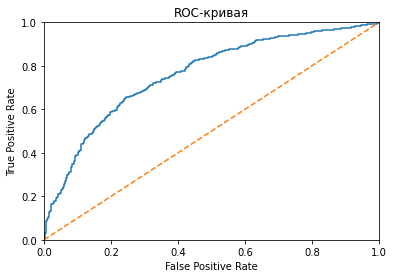

In [32]:
fpr, tpr, thresholds = roc_curve(y_valid, LgR_probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Логистическая регрессия показала себя хуже остальных скорей всего потому что высокая точность модели объясняется высокой долей негативных ответов в валидационной выборке.

- Вывод
-Данные были разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно
-Обучены модели "Решающее Дерево", "Случайный лес", "Логистическая Регрессия" без учёта дисбаланса классов. Максимальное -значение метрики f1 = 0.57 получено при обучении модели случайного леса. Качество модели не удовлетворяет условию технического задания.
-Качество моделей также оценено по метрике roc_auc. Максимальное значение метрики roc_auc = 0.71 достигнуто при обучении модели дерево решений.
-Метрики f1 и roc_auc достигли максимальных значений при одинаковых настройках гиперпараметров.

## Борьба с дисбалансом

Для борьбы с дисбалансом классов используем:
- взвешивание классов (class_weight='balanced')
- увеличение выборки положительного класса (копирование объектов)
- уменьшение выборки отрицательного класса (sampling)
- перемешивание объектов методом shuffle

### Взвешивание классов

In [33]:
decision_tree(X_train, X_valid, y_train, y_valid, cw='balanced')

Наилучшая метрика f1: 0.567
    Параметры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 9
       criterion = gini 

Наилучшая метрика roc_auc: 0.75
    Параметры модели:
       max_depth = 6
       min_samples_split = 2
       min_samples_leaf = 6
       criterion = gini 


Взвешивание классов почти не дало прироста в метрике f1 на решающем дереве. Но увилечелась метрика roc_auc до 0,75
Отметим, что в данном случае наилучшие значения метрик f1 и roc_auc достигаются при различных настройках гиперпараметров.
Применим upsampling и downsampling. Проверим результаты на модели случайного леса (она дала наилучший результат при начальном исследовании)

In [34]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [35]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

In [36]:
X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, 2)
X_train_balanced, y_train_balanced = downsample(X_train_upsampled, y_train_upsampled, 0.75)

In [37]:
random_forest(X_train_balanced, X_valid, y_train_balanced, y_valid)

Наилучшая метрика f1: 0.616
    Параметры модели:
       n_estimators = 20
       max_depth = 12
       min_samples_split = 2
       min_samples_leaf = 2 

Наилучшая метрика roc_auc: 0.752
    Параметры модели:
       n_estimators = 20
       max_depth = 12
       min_samples_split = 2
       min_samples_leaf = 2 


In [38]:
decision_tree(X_train_balanced, X_valid, y_train_balanced, y_valid)

Наилучшая метрика f1: 0.576
    Параметры модели:
       max_depth = 7
       min_samples_split = 2
       min_samples_leaf = 2
       criterion = entropy 

Наилучшая метрика roc_auc: 0.746
    Параметры модели:
       max_depth = 6
       min_samples_split = 2
       min_samples_leaf = 3
       criterion = gini 


- Метрика f1 для модели "Случайный лес" достигла значения 0.61 на сбалансированной выборке, что удовлетворяет условию технического задания.
- Для модели "Решающее дерево" метрика f1 не достигла минимально допустимого значения 0.59.
- Наилучшие значения метрик f1 и roc_auc достигли на случайном лесе при одинаковых значениях гиперпараметров. Для решающего дерева оптимальные значения гиперпараметров различаются.

- Как вариант можно попробовать для модели случайного леса подобрать различные варианты upsampling и downsampling (изменять параметры repeat и fraction).


In [39]:
for rep in range(2,4):
    for frac in np.arange(0.5, 0.8, 0.05):
        print('=====================================')
        print('repeat = {};   fraction = {}'.format(rep, round(frac,2)))
        X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, rep)
        X_train_balanced, y_train_balanced = downsample(X_train_upsampled, y_train_upsampled, frac)
        decision_tree(X_train_balanced, X_valid, y_train_balanced, y_valid)

repeat = 2;   fraction = 0.5
Наилучшая метрика f1: 0.571
    Параметры модели:
       max_depth = 9
       min_samples_split = 2
       min_samples_leaf = 8
       criterion = entropy 

Наилучшая метрика roc_auc: 0.756
    Параметры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 8
       criterion = entropy 
repeat = 2;   fraction = 0.55
Наилучшая метрика f1: 0.591
    Параметры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 

Наилучшая метрика roc_auc: 0.76
    Параметры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 
repeat = 2;   fraction = 0.6
Наилучшая метрика f1: 0.584
    Параметры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 7
       criterion = gini 

Наилучшая метрика roc_auc: 0.76
    Параметры модели:
       max_depth = 7
       min_samples_split = 2
       min_samples_leaf =

- В итоге получилось достичь наилучшего результата для решающего дерева при увеличении + класса в 2 раза и сэплировании - класса 0,55. 
- f1 0.59 а roc_auc: 0.76, по тех заданию проходит.

### Вывод

- Взвешивание классов с помощью параметра class_weight не дало значительного увеличения метрики f1.
- Upsampling положительного класса и downsampling отрицательного класса дали необходимый прирост точности моделей.
- Необходимое качество на валидационной выборке получили модели:
- Случайный лес:
- f1 = 0.616
- roc_auc = 0.752
- repeat = 2 - повторение объектов класса 1
- fraction = 0.75 - коэффициент сэмплирования объектов класса 0
- Решающее дерево:
- f1 = 0.591
- roc_auc = 0.76
- repeat = 2
- fraction = 0.55

## Тестирование модели

### Решающее дерево

In [40]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 2)
X_balanced, y_balanced = downsample(X_upsampled, y_upsampled, 0.55)
model_dtc_final = DecisionTreeClassifier(random_state=123,
                                         max_depth=8,
                                         min_samples_split=2,
                                         min_samples_leaf=4)
model_dtc_final.fit(X_balanced, y_balanced)
predictions_dtc = model_dtc_final.predict(X_test)
f1 = f1_score(y_test, predictions_dtc)

final_model_DTC_one = model_dtc_final.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, final_model_DTC_one)

print(' f1 = {}, \n roc_auc = {}'.format(round(f1,2), round(roc_auc,2)))

 f1 = 0.61, 
 roc_auc = 0.84


### Случайный лес

In [41]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 2)
X_balanced, y_balanced = downsample(X_upsampled, y_upsampled, 0.75)
model_rfc_final = RandomForestClassifier(random_state=123,
                                         n_estimators=15,
                                         max_depth=14,
                                         min_samples_split=4,
                                         min_samples_leaf=1)
model_rfc_final.fit(X_balanced, y_balanced)
predictions_rfc = model_rfc_final.predict(X_test)
f1 = f1_score(y_test, predictions_rfc)

final_model_RFC_one = model_rfc_final.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, final_model_RFC_one)

print(' f1 = {}, \n roc_auc = {}'.format(round(f1,2), round(roc_auc,2)))

 f1 = 0.6, 
 roc_auc = 0.84


- На моделях Решающее дерево и Случайный лес получилось получить значение метрики f1 согласно тех заданию
- Решающее дерево  f1 = 0.62, roc_auc = 0.84
- Случайный лес f1 = 0.61, roc_auc = 0.84


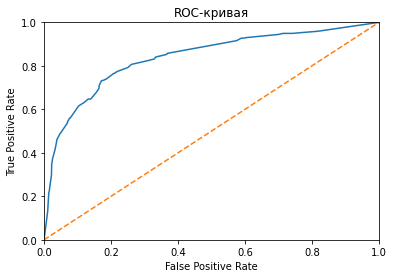

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, final_model_DTC_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

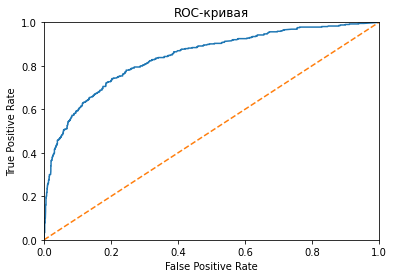

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, final_model_RFC_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Вывод по работе

- Произведена предобработка данных.
- Категориальные признаки преобразованы методом One-Hot Encoder.
- Проведён анализ моделей без учёта дисбаланса классов.
- Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно
- Обучены модели "Решающее Дерево", "Случайный лес", "Логистическая Регрессия" без учёта дисбаланса классов. Максимальное значение метрики f1 = 0.56 получено при обучении моделей случайного леса и дерево решений.
- Качество моделей также оценено по метрике roc_auc. Максимальное значение метрики roc_auc = 0.71 достигнуто при обучении модели Решающее дерево.
- Метрики f1 и roc_auc достигли максимальных значений при одинаковых настройках гиперпараметров.
- Проведён анализ дисбаланса классов
- Взвешивание классов с помощью параметра class_weight не дало значительного увеличения метрики f1.
- Upsampling положительного класса и downsampling отрицательного класса дали необходимый прирост точности моделей.
- Необходимое значение f1 на валидационной выборке получили модели:
- Случайный лес:
- f1 = 0.61
- roc_auc = 0.74
- Решающее дерево:
- f1 = 0.604
- roc_auc = 0.769
- Проведено тестирование полученных моделей на тестовой выборке:
- Значение метрики f1 на тестовой выборке:
- Случайный лес:
- f1 = 0.61
- roc_auc = 0.84
- Решающее дерево:
- f1 = 0.62
- roc_auc = 0.84
- Метрика f1 выше у модели Решающее дерево, roc_auc выше у Решающего дерева.